In [1]:
# === Non-S7 ML (coeffs + disc + j-invariants) — 60/40 split, full data 2025===
# Sage/Jupyter compatible

import os, ast, json, hashlib

import numpy as np
import pandas as pd
from builtins import int as pyint, float as pyfloat  # avoid Sage Integer/Real issues

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GroupKFold
)

# StratifiedGroupKFold may not exist in all sklearn versions
try:
    from sklearn.model_selection import StratifiedGroupKFold
    HAS_SGF = True
except Exception:
    HAS_SGF = False

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils import check_random_state

from joblib import dump

# ---------------- Config ----------------
CSV_PATH = "/Users/jurimezini/Library/CloudStorage/Dropbox/Sage_Galois7/AIMS-Galois-7/AIMS-7inv.2025.csv"
OUT_DIR  = os.path.join(os.path.dirname(CSV_PATH), "models_inv_nonS7_60_40")
os.makedirs(OUT_DIR, exist_ok=True)

RANDOM   = pyint(42)

# For this run we want the FULL dataset (no quick subsampling)
QUICK    = False
N_QUICK  = pyint(120000)   # only used if QUICK=True

# Feature toggles
USE_COEFFS = True
USE_DISC   = True      # disc_sign + disc_log10abs
USE_JINV   = True      # j0..j4

# Split controls
TEST_FRACTION     = pyfloat(0.40)  # 60/40 split
USE_GROUPED_SPLIT = False          # family-aware split off for now

# Canonical non-S7 label space + normalizations
CANON_NON_S7 = ["A7", "PSL(3,2)", "C7 ⋊ C3", "D7", "C7 ⋊ C6", "C7"]

NORMALIZE_GROUP = {
    "L(3,2": "PSL(3,2)",
    "L(3,2)": "PSL(3,2)",
    "7:2": "D7",
    "7:6": "C7 ⋊ C6",
}

MAP_7T = {
    "7T7": "S7",
    "7T6": "A7",
    "7T5": "PSL(3,2)",
    "7T3": "C7 ⋊ C3",
    "7T2": "D7",
    "7T4": "C7 ⋊ C6",
    "7T1": "C7",
}

# ---------------- Helpers ----------------
def signed_log10(X):
    """
    Elementwise sgn(x)*log10(1+|x|); stable for huge magnitudes; preserves sign.
    Used for j-invariants.
    """
    X = np.asarray(X, dtype=np.float64)
    return np.sign(X) * np.log10(1.0 + np.abs(X))

def class_weight_samples(y_vec, power=0.5):
    """
    Per-sample weights ~ (median_count / class_count)^power to soften imbalance.
    """
    power = float(power)
    vals, counts = np.unique(y_vec, return_counts=True)
    med = np.median(counts)
    wmap = {c: (med / cnt) ** power for c, cnt in zip(vals, counts)}
    return np.array([wmap[c] for c in y_vec], dtype=np.float64), wmap

def parse_coeffs_tuple(cell):
    """
    Accept '(...)', '[...]', tuple/list/ndarray; return list[int] of length 8.
    """
    if isinstance(cell, (list, tuple, np.ndarray)):
        v = list(cell)
    elif isinstance(cell, str):
        v = ast.literal_eval(cell)
    else:
        v = cell
    if v is None or len(v) != 8:
        raise ValueError(f"Expected 8 coefficients, got {v}")
    return [int(x) for x in v]

def stable_tuple_hash(row8):
    """
    Deterministic hash for an 8-int coefficient tuple (for grouping).
    """
    b = (",".join(map(str, row8))).encode("utf-8")
    return int(hashlib.sha1(b).hexdigest()[:12], 16)  # 48-bit int

# ---------------- Read CSV (robust) ----------------
df = pd.read_csv(CSV_PATH, low_memory=False)
df.columns = [str(c).strip() for c in df.columns]
print("COLUMNS:", list(df.columns))

# Prefer explicit a0..a7; expand tuple only if needed
coeff_cols = [f"a{i}" for i in range(8)]
have_all_coeffs = all(c in df.columns for c in coeff_cols)

if not have_all_coeffs:
    tuple_col = None
    for alt in ["coeffs_tuple_(a0..a7)", "coeffs_tuple", "coeffs"]:
        if alt in df.columns:
            tuple_col = alt
            break
    if tuple_col is None:
        raise ValueError("Need coefficients: either a0..a7 or a tuple column must be present.")

    df[tuple_col] = df[tuple_col].apply(parse_coeffs_tuple)
    coeff_mat = np.vstack(df[tuple_col].to_numpy()).astype(np.int64)
    df_coeffs = pd.DataFrame(coeff_mat, columns=coeff_cols, copy=False)
    df = pd.concat(
        [df.drop(columns=[tuple_col]).reset_index(drop=True),
         df_coeffs.reset_index(drop=True)],
        axis=1
    )

# Drop leftover textual 'coeffs' column to avoid confusion
if "coeffs" in df.columns and "coeffs" not in coeff_cols:
    try:
        df = df.drop(columns=["coeffs"])
    except Exception:
        pass

# ---- Add/repair discriminant-derived features if only raw 'disc' exists ----
if USE_DISC:
    if "disc_sign" not in df.columns and "disc" in df.columns:
        df["disc_sign"] = np.sign(pd.to_numeric(df["disc"], errors="coerce")).astype("float64")
    if "disc_log10abs" not in df.columns and "disc" in df.columns:
        df["disc_log10abs"] = np.log10(
            1.0 + np.abs(pd.to_numeric(df["disc"], errors="coerce"))
        )

# ---- Force numeric types where appropriate ----
numeric_cols = [c for c in
                ["disc", "disc_sign", "disc_log10abs",
                 "j0", "j1", "j2", "j3", "j4"] + coeff_cols
                if c in df.columns]

for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ---- Resolve/normalize labels robustly ----
label_col = None
for cand in ["group", "math_galois_notation", "galois_label"]:
    if cand in df.columns:
        label_col = cand
        break

if label_col is None:
    raise ValueError(f"No label column found; have columns: {list(df.columns)}")

if label_col == "galois_label":
    y_raw = df["galois_label"].astype(str).str.strip().map(MAP_7T)
else:
    y_raw = df[label_col].astype(str).str.strip()

y_raw = y_raw.replace(NORMALIZE_GROUP)

# Keep only canonical non-S7 classes
mask = y_raw.isin(CANON_NON_S7)
df   = df.loc[mask].reset_index(drop=True)
y    = y_raw.loc[mask].to_numpy(dtype=object)

print("Detected label column:", label_col)
print("Rows (non-S7 only):", len(df))
print("Class counts:", {c: int((y == c).sum()) for c in CANON_NON_S7})

# ---- Optional quick subset (OFF for this full-data run) ----
if QUICK and len(y) > N_QUICK:
    rng = check_random_state(0)
    idx = rng.choice(len(y), size=N_QUICK, replace=False)
    df, y = df.iloc[idx].reset_index(drop=True), y[idx]
    print(f"[QUICK] Using subset of {len(y)} rows")

# ---------------- Feature assembly ----------------
logj_cols  = [c for c in ["j0", "j1", "j2", "j3", "j4"] if USE_JINV and c in df.columns]
disc_cols  = [c for c in ["disc_sign", "disc_log10abs"] if USE_DISC and c in df.columns]
use_coeffs = [c for c in coeff_cols if USE_COEFFS and c in df.columns]

transformers = []

if logj_cols:
    transformers.append(
        ("logj",
         Pipeline([
             ("imp", SimpleImputer(strategy="median")),
             ("log", FunctionTransformer(signed_log10, feature_names_out="one-to-one")),
         ]),
         logj_cols)
    )

if disc_cols:
    transformers.append(
        ("disc",
         SimpleImputer(strategy="median"),
         disc_cols)
    )

if use_coeffs:
    transformers.append(
        ("coeffs",
         Pipeline([
             ("imp", SimpleImputer(strategy="constant", fill_value=pyint(0))),
         ]),
         use_coeffs)
    )

pre = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
    verbose_feature_names_out=False
)

clf = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.08,
    max_iter=500,
    max_leaf_nodes=31,
    min_samples_leaf=30,
    l2_regularization=1e-4,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=RANDOM,
)

pipe = Pipeline([("pre", pre), ("clf", clf)])

# ---------------- Build groups for optional leakage-resistant split ----------------
if USE_GROUPED_SPLIT:
    coeff_mat = df[[f"a{i}" for i in range(8)]].to_numpy(dtype=np.int64)
    g_hash = np.array([stable_tuple_hash(row) for row in coeff_mat], dtype=np.int64)
    height_bin = (
        pd.to_numeric(df.get("height", 0), errors="coerce")
        .fillna(0).astype(np.int64).to_numpy()
    )
    groups = (height_bin.astype(np.int64) * 10**6 + (g_hash % 10**6)).astype(np.int64)
else:
    groups = None

# ---------------- External 60/40 hold-out ----------------
if USE_GROUPED_SPLIT:
    from sklearn.model_selection import GroupShuffleSplit
    gss = GroupShuffleSplit(n_splits=1, test_size=float(TEST_FRACTION),
                            random_state=RANDOM)
    tr_idx, te_idx = next(gss.split(df, y, groups=groups))
    X_tr, X_te = df.iloc[tr_idx], df.iloc[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]
    g_tr, g_te = groups[tr_idx], groups[te_idx]
else:
    X_tr, X_te, y_tr, y_te = train_test_split(
        df, y,
        test_size=float(TEST_FRACTION),
        random_state=RANDOM,
        stratify=y
    )
    g_tr = g_te = None

print(f"Train size: {len(y_tr)} (60%);  Test size: {len(y_te)} (40%)")

# ---------------- 5-fold CV on TRAIN ----------------
cv_scores = []

if USE_GROUPED_SPLIT and HAS_SGF:
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM)
    splitter = cv.split(X_tr, y_tr, groups=g_tr)
elif USE_GROUPED_SPLIT:
    cv = GroupKFold(n_splits=5)
    splitter = cv.split(X_tr, groups=g_tr)
else:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM)
    splitter = cv.split(X_tr, y_tr)

for fold, (tr_idx, va_idx) in enumerate(splitter, 1):
    y_tr_fold = y_tr[tr_idx] if isinstance(y_tr, np.ndarray) else np.asarray(y_tr)[tr_idx]
    w_fold, _ = class_weight_samples(y_tr_fold, power=0.5)
    pipe.fit(X_tr.iloc[tr_idx], y_tr_fold, clf__sample_weight=w_fold)
    pred_va = pipe.predict(X_tr.iloc[va_idx])
    ba = balanced_accuracy_score(y_tr[va_idx], pred_va)
    cv_scores.append(ba)

print(f"[CV on train] Balanced accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# ---------------- Final fit on ALL TRAIN; evaluate on TEST ----------------
w_tr_all, wmap = class_weight_samples(y_tr, power=0.5)
print("Weight map (train):", {k: round(v, 3) for k, v in wmap.items()})

pipe.fit(X_tr, y_tr, clf__sample_weight=w_tr_all)

pred_te = pipe.predict(X_te)
print(f"\n[Test {int(TEST_FRACTION*100)}%] Balanced accuracy: "
      f"{balanced_accuracy_score(y_te, pred_te):.4f}\n")

print("[Test] Classification report")
print(classification_report(y_te, pred_te, labels=CANON_NON_S7,
                            digits=4, zero_division=0))

print("\n[Test] Confusion matrix (rows=true, cols=pred):")
cm = pd.DataFrame(
    confusion_matrix(y_te, pred_te, labels=CANON_NON_S7),
    index=CANON_NON_S7,
    columns=CANON_NON_S7
)
print(cm)

# ---------------- Save model + config ----------------
model_path = os.path.join(OUT_DIR, "nonS7_invariants_60_40_full.joblib")
dump(pipe, model_path)
print("Saved model to:", model_path)

config = {
    "label_space": [str(c) for c in CANON_NON_S7],
    "columns_in": [str(c) for c in df.columns],
    "feature_blocks": {
        "coeffs": [str(c) for c in use_coeffs],
        "disc":   [str(c) for c in disc_cols],
        "j_invariants": [str(c) for c in logj_cols],
    },
    "quick_mode": bool(QUICK),
    "test_fraction": float(TEST_FRACTION),
    "grouped_split": bool(USE_GROUPED_SPLIT),
}
with open(os.path.join(OUT_DIR, "config.json"), "w", encoding="utf-8") as f:
    json.dump(config, f, indent=2, ensure_ascii=False)

try:
    feats_out = pipe.named_steps["pre"].get_feature_names_out()
    with open(os.path.join(OUT_DIR, "features_out.txt"), "w", encoding="utf-8") as f:
        for nm in feats_out:
            f.write(f"{nm}\n")
except Exception:
    pass

print("Config and feature names saved in:", OUT_DIR)

# ---------------- One-off prediction helper ----------------
def predict_one(coeffs8=None,
                disc_sign=None,
                disc_log10abs=None,
                j0=None, j1=None, j2=None, j3=None, j4=None):
    """
    Predict a Galois group for a single septic.
    Provide what you have; missing values are imputed as in training.
    """
    row = {}

    if USE_COEFFS:
        if coeffs8 is None or len(coeffs8) != 8:
            raise ValueError("coeffs8 must be length-8 when USE_COEFFS=True")
        for i, v in enumerate(coeffs8):
            row[f"a{i}"] = int(v)

    if USE_DISC:
        row["disc_sign"]     = None if disc_sign is None else int(disc_sign)
        row["disc_log10abs"] = None if disc_log10abs is None else float(disc_log10abs)

    if USE_JINV:
        for name, val in zip(["j0", "j1", "j2", "j3", "j4"], [j0, j1, j2, j3, j4]):
            row[name] = None if val is None else float(val)

    X1 = pd.DataFrame([row], columns=pipe.named_steps["pre"].feature_names_in_)
    return pipe.predict(X1)[0]


COLUMNS: ['label', 'coeffs', 'disc', 'galois_label', 'class_group', 'math_galois_notation', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'poly_str', 'disc_sign', 'disc_log10abs', 'j0', 'j1', 'j2', 'j3', 'j4']
Detected label column: math_galois_notation
Rows (non-S7 only): 126396
Class counts: {'A7': 56997, 'PSL(3,2)': 40977, 'C7 ⋊ C3': 24457, 'D7': 2163, 'C7 ⋊ C6': 1550, 'C7': 252}
Train size: 75837 (60%);  Test size: 50559 (40%)
[CV on train] Balanced accuracy: 0.8410 ± 0.0132
Weight map (train): {'A7': 0.483, 'C7': 7.272, 'C7 ⋊ C3': 0.738, 'C7 ⋊ C6': 2.93, 'D7': 2.48, 'PSL(3,2)': 0.57}

[Test 40%] Balanced accuracy: 0.8525

[Test] Classification report
              precision    recall  f1-score   support

          A7     0.7729    0.8850    0.8252     22799
    PSL(3,2)     0.7969    0.6374    0.7083     16391
     C7 ⋊ C3     0.9995    0.9970    0.9983      9783
          D7     0.8274    0.8925    0.8587       865
     C7 ⋊ C6     0.8802    0.7823    0.8284       620
         

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit nicer
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.size"] = 11
plt.rcParams["axes.grid"] = True

CSV_PATH = "/Users/jurimezini/Library/CloudStorage/Dropbox/Sage_Galois7/AIMS-Galois-7/AIMS-7inv.2025.csv"

df = pd.read_csv(CSV_PATH, low_memory=False)

# Normalize label column
label_col = "math_galois_notation"
df[label_col] = df[label_col].astype(str).str.strip()

# Non-S7 only
nonS7 = df[df[label_col] != "S7"].copy()
CANON_NON_S7 = ["A7", "PSL(3,2)", "C7 ⋊ C3", "D7", "C7 ⋊ C6", "C7"]
nonS7 = nonS7[nonS7[label_col].isin(CANON_NON_S7)]


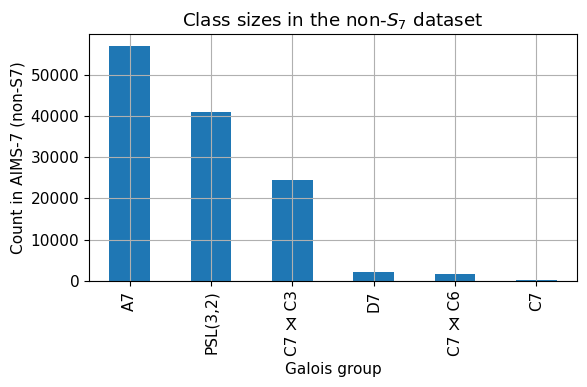

In [8]:
class_counts = nonS7[label_col].value_counts().reindex(CANON_NON_S7)

fig, ax = plt.subplots()
class_counts.plot(kind="bar", ax=ax)
ax.set_xlabel("Galois group")
ax.set_ylabel("Count in AIMS-7 (non-S7)")
ax.set_title("Class sizes in the non-$S_7$ dataset")
plt.tight_layout()

# Save for LaTeX
plt.savefig("fig_nonS7_class_counts.pdf")
plt.savefig("fig_nonS7_class_counts.png", dpi=300)
plt.show()


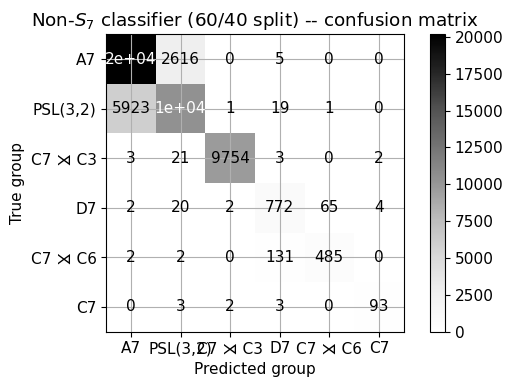

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_te, pred_te,
    labels=CANON_NON_S7,
    display_labels=CANON_NON_S7,
    cmap="Greys"
)
plt.xlabel("Predicted group")
plt.ylabel("True group")
plt.title("Non-$S_7$ classifier (60/40 split) -- confusion matrix")
plt.tight_layout()
plt.savefig("fig_nonS7_cm_60_40.pdf")
plt.savefig("fig_nonS7_cm_60_40.png", dpi=300)
plt.show()


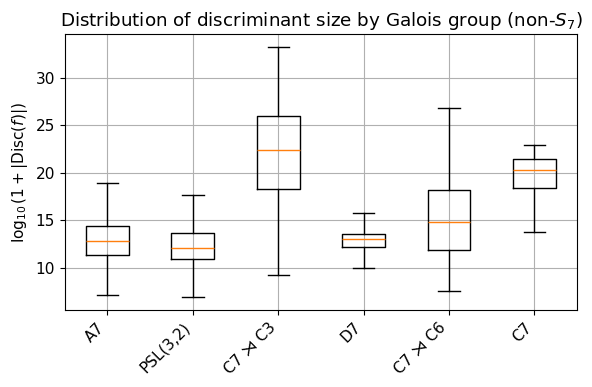

In [12]:
fig, ax = plt.subplots()
ax.boxplot(data, labels=CANON_NON_S7, showfliers=False)

ax.set_ylabel(r"$\log_{10}(1+|\mathrm{Disc}(f)|)$")
ax.set_title("Distribution of discriminant size by Galois group (non-$S_7$)")

plt.xticks(rotation=45, ha="right")
fig.tight_layout()          # use fig.tight_layout() (cleaner than plt.tight_layout)

fig.savefig("fig_nonS7_disc_boxplot.pdf")
fig.savefig("fig_nonS7_disc_boxplot.png", dpi=300)
plt.show()


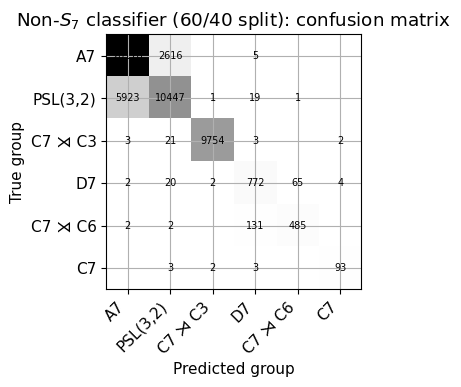

In [10]:
cm_counts = np.array([
    [20178,  2616,    0,   5,   0,  0],
    [ 5923, 10447,    1,  19,   1,  0],
    [    3,   21,  9754,   3,   0,  2],
    [    2,   20,    2, 772,  65,  4],
    [    2,    2,    0, 131, 485,  0],
    [    0,    3,    2,   3,   0, 93],
])

fig, ax = plt.subplots()
im = ax.imshow(cm_counts, cmap="Greys")

ax.set_xticks(range(len(CANON_NON_S7)))
ax.set_yticks(range(len(CANON_NON_S7)))
ax.set_xticklabels(CANON_NON_S7, rotation=45, ha="right")
ax.set_yticklabels(CANON_NON_S7)

ax.set_xlabel("Predicted group")
ax.set_ylabel("True group")
ax.set_title("Non-$S_7$ classifier (60/40 split): confusion matrix")

# Optional: annotate with counts
for i in range(cm_counts.shape[0]):
    for j in range(cm_counts.shape[1]):
        val = cm_counts[i, j]
        if val > 0:
            ax.text(j, i, str(val),
                    ha="center", va="center", fontsize=7)

plt.tight_layout()
plt.savefig("fig_nonS7_cm_60_40_manual.pdf")
plt.savefig("fig_nonS7_cm_60_40_manual.png", dpi=300)
plt.show()


In [37]:
#Machine Learning Model 80/20
# === Non-S7 ML (coeffs + discriminant features + j-invariants) ===


import os, ast, json
import numpy as np
import pandas as pd
from builtins import int as pyint, float as pyfloat  # avoid Sage Integer/Real issues

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier
from joblib import dump

# ---------------- Config ----------------
CSV_PATH   = "/Users/jurimezini/Library/CloudStorage/Dropbox/Sage_Galois7/AIMS-Galois-7/AIMS-7inv.2025.csv"
OUT_DIR    = os.path.join(os.path.dirname(CSV_PATH), "models_inv_nonS7")
os.makedirs(OUT_DIR, exist_ok=True)

RANDOM     = pyint(42)
QUICK      = True          # set False for full run
N_QUICK    = 120_000       # cap for quick smoke test

# Feature toggles (for ablations if needed)
USE_COEFFS = True
USE_DISC   = True          # uses disc_sign + disc_log10abs (not raw disc)
USE_JINV   = True          # j0..j4

# Canonical non-S7 label space + normalizations
CANON_NON_S7 = ["A7", "PSL(3,2)", "C7 ⋊ C3", "D7", "C7 ⋊ C6", "C7"]
NORMALIZE_GROUP = {
    "L(3,2": "PSL(3,2)", "L(3,2)": "PSL(3,2)",
    "7:2": "D7", "7:6": "C7 ⋊ C6"
}
MAP_7T = {"7T7":"S7","7T6":"A7","7T5":"PSL(3,2)","7T3":"C7 ⋊ C3",
          "7T2":"D7","7T4":"C7 ⋊ C6","7T1":"C7"}

# ---------------- Helpers ----------------
def signed_log10(X):
    """Elementwise sgn(x)*log10(1+|x|); stable for huge magnitudes; preserves sign."""
    X = np.asarray(X, dtype=np.float64)
    return np.sign(X) * np.log10(1.0 + np.abs(X))

def class_weight_samples(y_vec, power=0.5):
    """Per-sample weights ~ (median_count / class_count)^power to soften imbalance."""
    power = float(power)
    vals, counts = np.unique(y_vec, return_counts=True)
    med = np.median(counts)
    wmap = {c: (med / cnt) ** power for c, cnt in zip(vals, counts)}
    return np.array([wmap[c] for c in y_vec]), wmap

def parse_coeffs_tuple(cell):
    """Accept '(...)', '[...]', tuple/list/ndarray; return list[int] of length 8."""
    if isinstance(cell, (list, tuple, np.ndarray)):
        v = list(cell)
    elif isinstance(cell, str):
        v = ast.literal_eval(cell)
    else:
        v = cell
    if v is None or len(v) != 8:
        raise ValueError(f"Expected 8 coefficients, got {v}")
    return [int(x) for x in v]

# ---------------- Read CSV (robust) ----------------
df = pd.read_csv(CSV_PATH, low_memory=False)
df.columns = [str(c).strip() for c in df.columns]
print("COLUMNS:", list(df.columns))

# Prefer explicit a0..a7; expand tuple only if needed; drop stray 'coeffs' string column
coeff_cols = [f"a{i}" for i in range(8)]
have_all_coeffs = all(c in df.columns for c in coeff_cols)

# If both tuple and expanded exist, keep expanded and drop the tuple
if have_all_coeffs and "coeffs_tuple_(a0..a7)" in df.columns:
    df = df.drop(columns=["coeffs_tuple_(a0..a7)"])

# If expanded missing, try to expand from a tuple column (either name)
if not have_all_coeffs:
    tuple_col = None
    for alt in ["coeffs_tuple_(a0..a7)", "coeffs_tuple", "coeffs"]:
        if alt in df.columns:
            tuple_col = alt
            break
    if tuple_col is None:
        raise ValueError("Need coefficients: either a0..a7 or a tuple column must be present.")
    df[tuple_col] = df[tuple_col].apply(parse_coeffs_tuple)
    coeff_mat = np.vstack(df[tuple_col].to_numpy()).astype(np.int64)
    df_coeffs = pd.DataFrame(coeff_mat, columns=coeff_cols, copy=False)
    df = pd.concat(
        [df.drop(columns=[tuple_col]).reset_index(drop=True),
         df_coeffs.reset_index(drop=True)],
        axis=1
    )

# Drop any leftover textual 'coeffs' column to avoid confusion
if "coeffs" in df.columns and "coeffs" not in coeff_cols:
    try:
        df = df.drop(columns=["coeffs"])
    except Exception:
        pass

# Safety: ensure no duplicate column names remain
dups = df.columns[df.columns.duplicated()].tolist()
if dups:
    print("WARNING duplicate columns:", dups)

# ---- Force numeric types where appropriate (don't touch non-numerics) ----
numeric_cols = [c for c in ["disc","disc_sign","disc_log10abs","j0","j1","j2","j3","j4"] + coeff_cols if c in df.columns]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ---- Resolve/normalize labels robustly ----
label_col = None
for cand in ["group", "math_galois_notation", "galois_label"]:
    if cand in df.columns:
        label_col = cand
        break
if label_col is None:
    raise ValueError(f"No label column found; have columns: {list(df.columns)}")

if label_col == "galois_label":
    y_raw = df["galois_label"].astype(str).str.strip().map(MAP_7T)
else:
    y_raw = df[label_col].astype(str).str.strip()

y_raw = y_raw.replace(NORMALIZE_GROUP)  # fix L(3,2, etc.)

# Keep only canonical non-S7 classes
mask = y_raw.isin(CANON_NON_S7)
df   = df.loc[mask].reset_index(drop=True)
y    = y_raw.loc[mask].to_numpy(dtype=object)

print("Detected label column:", label_col)
print("Rows (non-S7 only):", len(df))
print("Class counts:", {c: int((y == c).sum()) for c in CANON_NON_S7})

# ---- Optional quick subset for a fast smoke test ----
if QUICK and len(y) > N_QUICK:
    rng = np.random.RandomState(0)
    idx = rng.choice(len(y), size=N_QUICK, replace=False)
    df, y = df.iloc[idx].reset_index(drop=True), y[idx]
    print(f"[QUICK] Using subset of {len(y)} rows")

# ---------------- Feature assembly ----------------
logj_cols  = [c for c in ["j0","j1","j2","j3","j4"] if USE_JINV and c in df.columns]
disc_cols  = [c for c in ["disc_sign","disc_log10abs"] if USE_DISC and c in df.columns]
use_coeffs = [c for c in coeff_cols if USE_COEFFS and c in df.columns]

transformers = []
if logj_cols:
    transformers.append(
        ("logj",
         Pipeline([
             ("imp", SimpleImputer(strategy="median")),
             ("log", FunctionTransformer(signed_log10, feature_names_out="one-to-one"))
         ]),
         logj_cols)
    )
if disc_cols:
    transformers.append(("disc", SimpleImputer(strategy="median"), disc_cols))
if use_coeffs:
    transformers.append(
        ("coeffs",
         Pipeline([
             # ✅ Sage-safe constant: use Python int via pyint(0)
             ("imp", SimpleImputer(strategy="constant", fill_value=pyint(0))),
             # Optional cast (uncomment if you prefer floats): 
             # ("cast", FunctionTransformer(lambda X: X.astype(np.float64), feature_names_out="one-to-one")),
         ]),
         use_coeffs)
    )

pre = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
    verbose_feature_names_out=False
)

clf = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.08,
    max_iter=500,
    max_leaf_nodes=31,
    min_samples_leaf=30,
    l2_regularization=1e-4,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=RANDOM
)

pipe = Pipeline([("pre", pre), ("clf", clf)])

# ---------------- Split ----------------
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    df, y, test_size=pyfloat(0.20), random_state=RANDOM, stratify=y
)
X_va, X_te, y_va, y_te = train_test_split(
    X_tmp, y_tmp, test_size=pyfloat(0.50), random_state=RANDOM, stratify=y_tmp
)

# ---------------- Train with soft class weighting ----------------
w_tr, wmap = class_weight_samples(y_tr, power=pyfloat(0.5))
print("Weight map:", {k: round(v, 3) for k,v in wmap.items()})

pipe.fit(X_tr, y_tr, clf__sample_weight=w_tr)

# ---------------- Evaluate ----------------
pred_va = pipe.predict(X_va)
pred_te = pipe.predict(X_te)

print("\n[Validation] Balanced accuracy:", round(balanced_accuracy_score(y_va, pred_va), 4))
print("[Test]       Balanced accuracy:", round(balanced_accuracy_score(y_te, pred_te), 4))

print("\n[Validation] Classification report")
print(classification_report(y_va, pred_va, labels=CANON_NON_S7, digits=4, zero_division=0))

print("\n[Test] Confusion matrix (rows=true, cols=pred):")
cm = pd.DataFrame(confusion_matrix(y_te, pred_te, labels=CANON_NON_S7),
                  index=CANON_NON_S7, columns=CANON_NON_S7)
print(cm)

# ---------------- Save ----------------
dump(pipe, os.path.join(OUT_DIR, "nonS7_invariants.joblib"))
with open(os.path.join(OUT_DIR, "config.json"), "w") as f:
    json.dump({
        "label_space": CANON_NON_S7,
        "columns_in": list(df.columns),
        "feature_blocks": {
            "coeffs": use_coeffs,
            "disc":   disc_cols,
            "j_invariants": logj_cols
        },
        "quick_mode": QUICK
    }, f, indent=2)

# Also store the transformed feature names
try:
    feats_out = pipe.named_steps["pre"].get_feature_names_out()
    with open(os.path.join(OUT_DIR, "features_out.txt"), "w") as f:
        for nm in feats_out:
            f.write(f"{nm}\n")
except Exception:
    pass

print("Saved to:", OUT_DIR)

# ---------------- One-off prediction helper ----------------
def predict_one(coeffs8=None, disc_sign=None, disc_log10abs=None, j0=None, j1=None, j2=None, j3=None, j4=None):
    """
    Provide what you have; missing values are imputed as in training.
    Example:
        predict_one(coeffs8=[1,-1,-1,1,-1,-1,2,1],
                    disc_sign=-1, disc_log10abs=5.553775,
                    j0=-38458, j1=4770350768, j2=4.8015819586158288e16,
                    j3=-1.290474031679648e15, j4=None)
    """
    row = {}
    if USE_COEFFS:
        if coeffs8 is None or len(coeffs8) != 8:
            raise ValueError("coeffs8 must be length-8 when USE_COEFFS=True")
        for i, v in enumerate(coeffs8):
            row[f"a{i}"] = int(v)

    if USE_DISC:
        row["disc_sign"]     = None if disc_sign is None else int(disc_sign)
        row["disc_log10abs"] = None if disc_log10abs is None else float(disc_log10abs)

    if USE_JINV:
        for name, val in zip(["j0","j1","j2","j3","j4"], [j0,j1,j2,j3,j4]):
            row[name] = None if val is None else float(val)

    # Ensure exact column alignment with what the preprocessor expects
    X1 = pd.DataFrame([row], columns=pipe.named_steps["pre"].feature_names_in_)
    return pipe.predict(X1)[0]

# Example usage (commented):
# print("Example predict:", predict_one(
#     coeffs8=[1,-1,-1,1,-1,-1,2,1],
#     disc_sign=-1, disc_log10abs=5.553775,
#     j0=-38458, j1=4.770350768e9, j2=4.8015819586158288e16, j3=-1.290474031679648e15, j4=None
# ))


COLUMNS: ['label', 'coeffs', 'disc', 'galois_label', 'class_group', 'math_galois_notation', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'poly_str', 'disc_sign', 'disc_log10abs', 'j0', 'j1', 'j2', 'j3', 'j4']
Detected label column: math_galois_notation
Rows (non-S7 only): 126396
Class counts: {'A7': 56997, 'PSL(3,2)': 40977, 'C7 ⋊ C3': 24457, 'D7': 2163, 'C7 ⋊ C6': 1550, 'C7': 252}
[QUICK] Using subset of 120000 rows
Weight map: {'A7': 0.483, 'C7': 7.408, 'C7 ⋊ C3': 0.738, 'C7 ⋊ C6': 2.927, 'D7': 2.483, 'PSL(3,2)': 0.57}

[Validation] Balanced accuracy: 0.8486
[Test]       Balanced accuracy: 0.8682

[Validation] Classification report
              precision    recall  f1-score   support

          A7     0.7711    0.8888    0.8258      5413
    PSL(3,2)     0.8023    0.6331    0.7077      3892
     C7 ⋊ C3     0.9996    0.9991    0.9994      2320
          D7     0.8476    0.8683    0.8578       205
     C7 ⋊ C6     0.8286    0.7891    0.8084       147
          C7     1.0000    0.9

In [38]:
#Machine Learning Model 50/50 split
#50/50
# === Non-S7 ML — 50/50 split (coeffs + discriminant features + j-invariants) ===
# Works in Sage/Jupyter. Paste and run.

import os, ast, json, hashlib
import numpy as np
import pandas as pd
from builtins import int as pyint, float as pyfloat

from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold
try:
    from sklearn.model_selection import StratifiedGroupKFold
    HAS_SGF = True
except Exception:
    HAS_SGF = False

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils import check_random_state
from joblib import dump

import matplotlib.pyplot as plt

# ---------------- Config ----------------
CSV_PATH = "/Users/jurimezini/Library/CloudStorage/Dropbox/Sage_Galois7/AIMS-Galois-7/AIMS-7inv.2025.csv"

OUT_DIR  = os.path.join(os.path.dirname(CSV_PATH), "models_inv_nonS7_50_50")
os.makedirs(OUT_DIR, exist_ok=True)

FIG_DIR  = "/Users/jurimezini/fig_nonS7_50_50"
os.makedirs(FIG_DIR, exist_ok=True)

RANDOM = pyint(42)
QUICK = False           # set True for a fast smoke test
N_QUICK = 120_000

# Feature toggles
USE_COEFFS = True
USE_DISC   = True       # uses disc_sign + disc_log10abs (auto-built from 'disc' if missing)
USE_JINV   = True       # j0..j4 (with signed log transform)

# Split controls
TEST_FRACTION     = pyfloat(0.50)  # 50% external test hold-out
USE_GROUPED_SPLIT = False          # True => family-aware split (height+tuple hash)

# Canonical non-S7 label space + normalizations
CANON_NON_S7 = ["A7", "PSL(3,2)", "C7 ⋊ C3", "D7", "C7 ⋊ C6", "C7"]
NORMALIZE_GROUP = {
    "L(3,2": "PSL(3,2)", "L(3,2)": "PSL(3,2)",
    "7:2": "D7", "7:6": "C7 ⋊ C6"
}
MAP_7T = {"7T7":"S7","7T6":"A7","7T5":"PSL(3,2)","7T3":"C7 ⋊ C3","7T2":"D7","7T4":"C7 ⋊ C6","7T1":"C7"}

# ---------------- Helpers ----------------
def signed_log10(X):
    X = np.asarray(X, dtype=np.float64)
    return np.sign(X) * np.log10(1.0 + np.abs(X))

def class_weight_samples(y_vec, power=0.5):
    vals, counts = np.unique(y_vec, return_counts=True)
    med = np.median(counts)
    wmap = {c: (med / cnt) ** float(power) for c, cnt in zip(vals, counts)}
    return np.array([wmap[c] for c in y_vec], dtype=np.float64), wmap

def parse_coeffs_tuple(cell):
    if isinstance(cell, (list, tuple, np.ndarray)): v = list(cell)
    elif isinstance(cell, str): v = ast.literal_eval(cell)
    else: v = cell
    if v is None or len(v) != 8:
        raise ValueError(f"Expected 8 coefficients, got {v}")
    return [int(x) for x in v]

def stable_tuple_hash(row8):
    b = (",".join(map(str, row8))).encode("utf-8")
    return int(hashlib.sha1(b).hexdigest()[:12], 16)  # 48-bit int

def _savefig(path_png, path_pdf):
    plt.tight_layout()
    plt.savefig(path_png, dpi=200, bbox_inches="tight")
    plt.savefig(path_pdf, bbox_inches="tight")
    plt.close()

def plot_cm(cm, labels, outstem):
    plt.figure(figsize=(6.2, 5.4))
    plt.imshow(cm, interpolation="nearest")  # default colormap
    plt.title("Confusion matrix — non-S7 (50/50)")
    plt.xticks(np.arange(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(np.arange(len(labels)), labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]), ha="center", va="center", fontsize=9)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    _savefig(os.path.join(FIG_DIR, f"{outstem}.png"), os.path.join(FIG_DIR, f"{outstem}.pdf"))

def plot_prec_recall(pr_dict, labels, outstem):
    precisions = [pr_dict.get(lbl, {}).get("precision", 0.0) for lbl in labels]
    recalls    = [pr_dict.get(lbl, {}).get("recall", 0.0) for lbl in labels]
    x = np.arange(len(labels)); w = 0.38
    plt.figure(figsize=(7.2, 4.4))
    plt.bar(x - w/2, precisions, width=w, label="Precision")
    plt.bar(x + w/2, recalls,    width=w, label="Recall")
    plt.xticks(x, labels, rotation=30, ha="right")
    plt.ylim(0, 1.0)
    plt.title("Per-class Precision & Recall — non-S7 (test, 50/50)")
    plt.legend()
    _savefig(os.path.join(FIG_DIR, f"{outstem}.png"), os.path.join(FIG_DIR, f"{outstem}.pdf"))

def plot_support_counts(counts, labels, outstem):
    vals = [int(counts.get(lbl, 0)) for lbl in labels]
    x = np.arange(len(labels))
    plt.figure(figsize=(7.2, 4.4))
    plt.bar(x, vals)
    plt.xticks(x, labels, rotation=30, ha="right")
    plt.title("Test support by class — non-S7 (50/50)")
    plt.ylabel("Count")
    _savefig(os.path.join(FIG_DIR, f"{outstem}.png"), os.path.join(FIG_DIR, f"{outstem}.pdf"))

# ---------------- Read CSV (robust to your schema) ----------------
df = pd.read_csv(CSV_PATH, low_memory=False)
df.columns = [str(c).strip() for c in df.columns]
print("COLUMNS:", list(df.columns))

coeff_cols = [f"a{i}" for i in range(8)]
if not all(c in df.columns for c in coeff_cols):
    tuple_col = None
    for alt in ["coeffs_tuple_(a0..a7)", "coeffs_tuple", "coeffs"]:
        if alt in df.columns:
            tuple_col = alt
            break
    if tuple_col is None:
        raise ValueError("Need coefficients: a0..a7 or a tuple column (e.g. 'coeffs_tuple_(a0..a7)')")
    df[tuple_col] = df[tuple_col].apply(parse_coeffs_tuple)
    coeff_mat = np.vstack(df[tuple_col].to_numpy()).astype(np.int64)
    df_coeffs = pd.DataFrame(coeff_mat, columns=coeff_cols, copy=False)
    df = pd.concat([df.drop(columns=[tuple_col]).reset_index(drop=True),
                    df_coeffs.reset_index(drop=True)], axis=1)

# Discriminant-derived fields (if missing)
if USE_DISC:
    if "disc_sign" not in df.columns and "disc" in df.columns:
        df["disc_sign"] = np.sign(pd.to_numeric(df["disc"], errors="coerce"))
    if "disc_log10abs" not in df.columns and "disc" in df.columns:
        df["disc_log10abs"] = np.log10(1.0 + np.abs(pd.to_numeric(df["disc"], errors="coerce")))

# Numeric coercion
numeric_cols = [c for c in ["disc","disc_sign","disc_log10abs","j0","j1","j2","j3","j4"] + coeff_cols if c in df.columns]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Label column (your sample shows 'label' NaN; real labels in 'group')
label_col = "group" if "group" in df.columns else (
    "math_galois_notation" if "math_galois_notation" in df.columns else (
        "galois_label" if "galois_label" in df.columns else None
))
if label_col is None:
    raise ValueError(f"No label column found; have columns: {list(df.columns)}")

if label_col == "galois_label":
    y_raw = df["galois_label"].astype(str).str.strip().map(MAP_7T)
else:
    y_raw = df[label_col].astype(str).str.strip()
y_raw = y_raw.replace(NORMALIZE_GROUP)

# Keep only canonical non-S7 classes
mask = y_raw.isin(CANON_NON_S7)
df   = df.loc[mask].reset_index(drop=True)
y    = y_raw.loc[mask].to_numpy(dtype=object)

print("Detected label column:", label_col)
print("Rows (non-S7 only):", len(df))
print("Class counts:", {c: int((y == c).sum()) for c in CANON_NON_S7})

if QUICK and len(y) > N_QUICK:
    rng = check_random_state(0)
    idx = rng.choice(len(y), size=N_QUICK, replace=False)
    df, y = df.iloc[idx].reset_index(drop=True), y[idx]
    print(f"[QUICK] Using subset of {len(y)} rows")

# ---------------- Feature assembly ----------------
logj_cols  = [c for c in ["j0","j1","j2","j3","j4"] if USE_JINV and c in df.columns]
disc_cols  = [c for c in ["disc_sign","disc_log10abs"] if USE_DISC and c in df.columns]
use_coeffs = [c for c in coeff_cols if USE_COEFFS and c in df.columns]

transformers = []
if logj_cols:
    transformers.append(("logj", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("log", FunctionTransformer(signed_log10, feature_names_out="one-to-one")),
    ]), logj_cols))
if disc_cols:
    transformers.append(("disc", SimpleImputer(strategy="median"), disc_cols))
if use_coeffs:
    transformers.append(("coeffs", Pipeline([
        ("imp", SimpleImputer(strategy="constant", fill_value=pyint(0))),
    ]), use_coeffs))

pre = ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

clf = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.08,
    max_iter=500,
    max_leaf_nodes=31,
    min_samples_leaf=30,
    l2_regularization=1e-4,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=RANDOM
)
pipe = Pipeline([("pre", pre), ("clf", clf)])

# ---------------- Optional leakage-resistant grouping ----------------
if USE_GROUPED_SPLIT:
    coeff_mat = df[[f"a{i}" for i in range(8)]].to_numpy(dtype=np.int64)
    g_hash = np.array([stable_tuple_hash(row) for row in coeff_mat], dtype=np.int64)
    height_bin = (pd.to_numeric(df.get("height", 0), errors="coerce").fillna(0).astype(np.int64).to_numpy())
    groups = (height_bin.astype(np.int64) * 10**6 + (g_hash % 10**6)).astype(np.int64)
else:
    groups = None

# ---------------- External 50% hold-out ----------------
if USE_GROUPED_SPLIT:
    from sklearn.model_selection import GroupShuffleSplit
    gss = GroupShuffleSplit(n_splits=1, test_size=float(TEST_FRACTION), random_state=RANDOM)
    tr_idx, te_idx = next(gss.split(df, y, groups=groups))
    X_tr, X_te = df.iloc[tr_idx], df.iloc[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]
    g_tr, g_te = groups[tr_idx], groups[te_idx]
else:
    X_tr, X_te, y_tr, y_te = train_test_split(df, y, test_size=float(TEST_FRACTION),
                                              random_state=RANDOM, stratify=y)
    g_tr = g_te = None

print(f"Train size: {len(y_tr)} (50%);  Test size: {len(y_te)} (50%)")

# ---------------- 5-fold CV on TRAIN ----------------
cv_scores = []
if USE_GROUPED_SPLIT and HAS_SGF:
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM)
    splitter = cv.split(X_tr, y_tr, groups=g_tr)
elif USE_GROUPED_SPLIT:
    cv = GroupKFold(n_splits=5)
    splitter = cv.split(X_tr, groups=g_tr)
else:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM)
    splitter = cv.split(X_tr, y_tr)

for fold, (tr_idx, va_idx) in enumerate(splitter, 1):
    y_tr_fold = np.asarray(y_tr)[tr_idx]
    w_fold, _ = class_weight_samples(y_tr_fold, power=0.5)
    pipe.fit(X_tr.iloc[tr_idx], y_tr_fold, clf__sample_weight=w_fold)
    pred_va = pipe.predict(X_tr.iloc[va_idx])
    ba = balanced_accuracy_score(y_tr[va_idx], pred_va)
    cv_scores.append(ba)
print(f"[CV on train] Balanced accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# ---------------- Final fit on ALL TRAIN; single evaluation on TEST ----------------
w_tr_all, wmap = class_weight_samples(y_tr, power=0.5)
print("Weight map (train):", {k: round(v, 3) for k, v in wmap.items()})
pipe.fit(X_tr, y_tr, clf__sample_weight=w_tr_all)

pred_te = pipe.predict(X_te)
ba_te = balanced_accuracy_score(y_te, pred_te)
print(f"\n[Test 50%] Balanced accuracy: {ba_te:.4f}")

# Full report + confusion matrix
report = classification_report(y_te, pred_te, labels=CANON_NON_S7, digits=4, zero_division=0, output_dict=True)
print("\n[Test] Classification report")
print(classification_report(y_te, pred_te, labels=CANON_NON_S7, digits=4, zero_division=0))

cm = confusion_matrix(y_te, pred_te, labels=CANON_NON_S7)
cm_df = pd.DataFrame(cm, index=CANON_NON_S7, columns=CANON_NON_S7)
print("\n[Test] Confusion matrix (rows=true, cols=pred):")
print(cm_df)

# ---------------- Save model + config ----------------
dump(pipe, os.path.join(OUT_DIR, "nonS7_invariants_50_50.joblib"))
config = {
    "label_space": [str(c) for c in CANON_NON_S7],
    "columns_in": [str(c) for c in df.columns],
    "feature_blocks": {
        "coeffs": [str(c) for c in use_coeffs],
        "disc":   [str(c) for c in disc_cols],
        "j_invariants": [str(c) for c in logj_cols],
    },
    "test_fraction": float(TEST_FRACTION),
    "grouped_split": bool(USE_GROUPED_SPLIT),
    "quick_mode": bool(QUICK),
}
with open(os.path.join(OUT_DIR, "config.json"), "w", encoding="utf-8") as f:
    json.dump(config, f, indent=2, ensure_ascii=False)

# ---------------- Save figures + CSV metrics ----------------
plot_cm(cm, CANON_NON_S7, outstem="cm_nonS7_50_50")

per_class = {lbl: {"precision": report.get(lbl, {}).get("precision", 0.0),
                   "recall":    report.get(lbl, {}).get("recall", 0.0),
                   "f1":        report.get(lbl, {}).get("f1-score", 0.0),
                   "support":   int(report.get(lbl, {}).get("support", 0))}
             for lbl in CANON_NON_S7}
plot_prec_recall(per_class, CANON_NON_S7, outstem="prec_recall_nonS7_50_50")
plot_support_counts({k: v["support"] for k, v in per_class.items()}, CANON_NON_S7, outstem="support_nonS7_50_50")

pd.DataFrame(
    [{"label": lbl, **per_class[lbl]} for lbl in CANON_NON_S7] +
    [{"label": "balanced_accuracy_test", "precision": "", "recall": "", "f1": float(ba_te), "support": ""}]
).to_csv(os.path.join(FIG_DIR, "nonS7_test_metrics_50_50.csv"), index=False)

print("\nSaved model to:", OUT_DIR)
print("Saved figures & CSV to:", FIG_DIR)

# ---------------- One-off prediction helper ----------------
def predict_one(coeffs8=None, disc_sign=None, disc_log10abs=None, j0=None, j1=None, j2=None, j3=None, j4=None):
    row = {}
    if USE_COEFFS:
        if coeffs8 is None or len(coeffs8) != 8:
            raise ValueError("coeffs8 must be length-8 when USE_COEFFS=True")
        for i, v in enumerate(coeffs8):
            row[f"a{i}"] = int(v)
    if USE_DISC:
        row["disc_sign"]     = None if disc_sign is None else int(disc_sign)
        row["disc_log10abs"] = None if disc_log10abs is None else float(disc_log10abs)
    if USE_JINV:
        for name, val in zip(["j0","j1","j2","j3","j4"], [j0,j1,j2,j3,j4]):
            row[name] = None if val is None else float(val)
    X1 = pd.DataFrame([row], columns=pipe.named_steps["pre"].feature_names_in_)
    return pipe.predict(X1)[0]


COLUMNS: ['label', 'coeffs', 'disc', 'galois_label', 'class_group', 'math_galois_notation', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'poly_str', 'disc_sign', 'disc_log10abs', 'j0', 'j1', 'j2', 'j3', 'j4']
Detected label column: math_galois_notation
Rows (non-S7 only): 126396
Class counts: {'A7': 56997, 'PSL(3,2)': 40977, 'C7 ⋊ C3': 24457, 'D7': 2163, 'C7 ⋊ C6': 1550, 'C7': 252}
Train size: 63198 (50%);  Test size: 63198 (50%)
[CV on train] Balanced accuracy: 0.8329 ± 0.0183
Weight map (train): {'A7': 0.483, 'C7': 7.268, 'C7 ⋊ C3': 0.738, 'C7 ⋊ C6': 2.93, 'D7': 2.481, 'PSL(3,2)': 0.57}

[Test 50%] Balanced accuracy: 0.8544

[Test] Classification report
              precision    recall  f1-score   support

          A7     0.7683    0.8873    0.8235     28499
    PSL(3,2)     0.7971    0.6267    0.7017     20488
     C7 ⋊ C3     0.9993    0.9970    0.9982     12228
          D7     0.8427    0.8909    0.8661      1082
     C7 ⋊ C6     0.8725    0.8039    0.8368       775
        